# 2. Data fetching and processing

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("../../").resolve()))

%load_ext autoreload
%autoreload 2

## More details about list_data

In [2]:
import pipeGEM as pg
from pipeGEM.data.fetching import list_models, load_remote_model

In [3]:
model_list = list_models(organism="human")

In [4]:
model_list

,id,organism,reaction_count,metabolite_count,gene_count,database
1,Human-GEM,Homo sapiens,13070,8369,3067,metabolic atlas
1,iAB_RBC_283,Homo sapiens,469,342,346,BiGG
12,iAT_PLT_636,Homo sapiens,1008,738,636,BiGG
105,RECON1,Homo sapiens,3741,2766,1905,BiGG
106,Recon3D,Homo sapiens,10600,5835,2248,BiGG


In [5]:
# select by number of components

model_list = list_models(organism="mouse", 
                         max_n_genes=2000, max_n_mets=3000, max_n_rxns=5000)

In [6]:
model_list

,id,organism,reaction_count,metabolite_count,gene_count,database
77,iMM1415,Mus musculus,3726,2775,1375,BiGG


## Generate simulated gene data

In [7]:
from pipeGEM.data.synthesis import get_syn_gene_data
import seaborn as sns
import numpy as np

In [8]:
mouse = load_remote_model('iMM1415')

No objective coefficients in model. Unclear what should be optimized


In [31]:
raw_count = get_syn_gene_data(mouse, n_sample=9, random_state=42)
raw_count.head()

,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8
12846,8.957240,45.815612,54.068168,40.203831,11.821764,39.643735,17.836579,51.316219,42.184034
67689,634.111227,494.279759,571.975162,495.923469,591.123251,452.231664,583.290323,618.978814,554.117346
237940,631.885730,795.849623,712.663831,581.774641,611.227857,705.169782,698.877466,715.904762,608.485627
222,224.044267,314.955652,228.648016,346.631269,243.114738,186.455571,208.876281,364.103235,335.927543
76507,466.856916,421.127353,617.754761,567.732988,486.535036,464.563532,545.220138,488.426071,492.063919


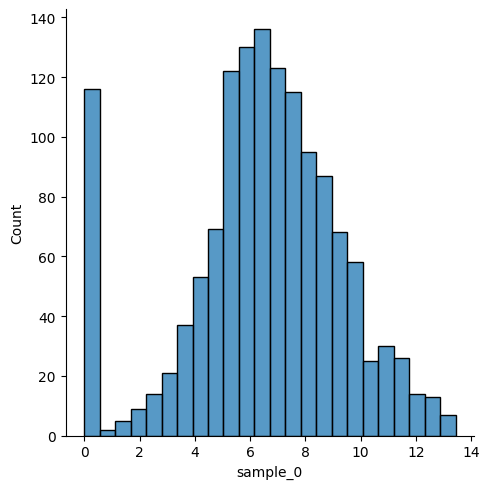

In [32]:
sns.displot(np.log2(raw_count + 1)["sample_0"])

## Maping gene data to a pipeGEM model

In [33]:
from pipeGEM.data import GeneData

In [34]:
p_mouse = pg.Model("imm1415", mouse)

In [35]:
gene_data = GeneData(data=raw_count["sample_0"], 
                     data_transform=lambda x: np.log2(x), 
                     absent_expression=0)

In [36]:
p_mouse.add_gene_data(name_or_prefix="sample_0", 
                      data=gene_data, 
                      or_operation="nanmax",  # alternative: nansum
                      threshold=-np.inf, 
                      absent_value=-np.inf)

100%|████████████████████████████████████████████████████████████████████████████| 3726/3726 [00:00<00:00, 8357.86it/s]

Finished mapping in 0.46775078773498535 seconds.


In [37]:
p_mouse.reactions.get_by_id("2HBt2")

Reaction identifier,2HBt2
Name,2 hydroxybutyrate cotransport with proton
Memory address,0x261eababf40
Stoichiometry,2hb_e + h_e <=> 2hb_c + h_c 2 Hydroxybutyrate C4H7O3 + H+ <=> 2 Hydroxybutyrate C4H7O3 + H+
GPR,80879 or 20503 or 20501
Lower bound,-100000.0
Upper bound,100000.0


In [38]:
p_mouse.gene_data["sample_0"].rxn_scores["2HBt2"]

C:\Users\user\AppData\Local\Temp\ipykernel_55056\3651060646.py:2: RuntimeWarning: divide by zero encountered in log2
  data_transform=lambda x: np.log2(x),


9.637423880451527

In [39]:
gene_data.transformed_gene_data["80879"], gene_data.transformed_gene_data["20503"], gene_data.transformed_gene_data["20501"]

C:\Users\user\AppData\Local\Temp\ipykernel_55056\3651060646.py:2: RuntimeWarning: divide by zero encountered in log2
  data_transform=lambda x: np.log2(x),


(9.637423880451527, 6.250806510160577, 6.129452830520364)

## Finding data thresholds

In [40]:
# modified rFASTCORMICS thresholds
rFASTCORMICS_threshold = gene_data.get_threshold("rFASTCORMICS", return_heuristic=False)

C:\Users\user\AppData\Local\Temp\ipykernel_55056\3651060646.py:2: RuntimeWarning: divide by zero encountered in log2
  data_transform=lambda x: np.log2(x),


p_score of init values: 0.05618615157520986
original guess:  5.528925121121564 9.039766989523379
best fitted Amps:  0.08358113339623165 0.10862504208812189
best fitted means:  7.757675952278785 6.2631072791589055


C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\analysis\_threshold.py:158: UserWarning: Fail to find proper parameters, return the best 3 params
  warnings.warn(f"Fail to find proper parameters, return the best {k} params")


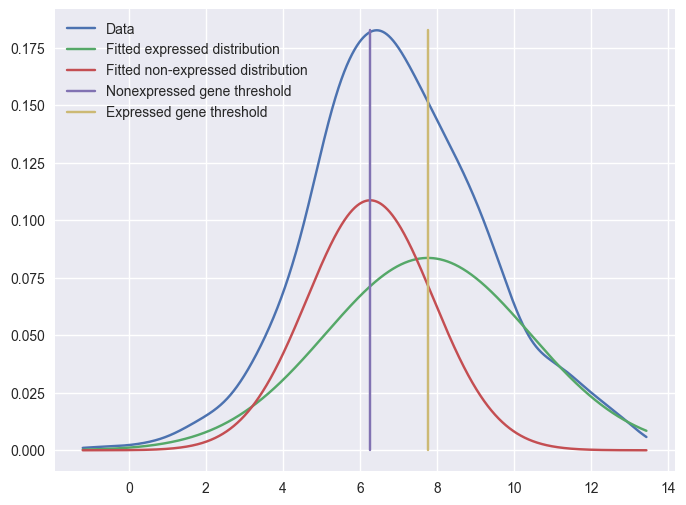

Expression threshold: 7.757675952278785


In [41]:
rFASTCORMICS_threshold.plot()
print(f"Expression threshold: {rFASTCORMICS_threshold.exp_th}")

In [42]:
# percentile thresholds (which are also called 'global threshold')
p90_threshold = gene_data.get_threshold("percentile", p=90)
p75_threshold = gene_data.get_threshold("percentile", p=75)
p50_threshold = gene_data.get_threshold("percentile", p=50)

C:\Users\user\AppData\Local\Temp\ipykernel_55056\3651060646.py:2: RuntimeWarning: divide by zero encountered in log2
  data_transform=lambda x: np.log2(x),


In [43]:
p50_threshold.exp_th, p75_threshold.exp_th, p90_threshold.exp_th

(6.836464350055813, 8.459408202208161, 9.901857412816293)

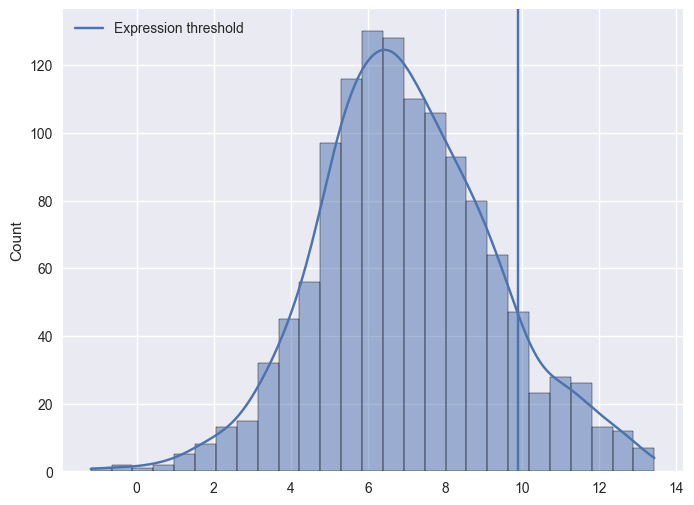

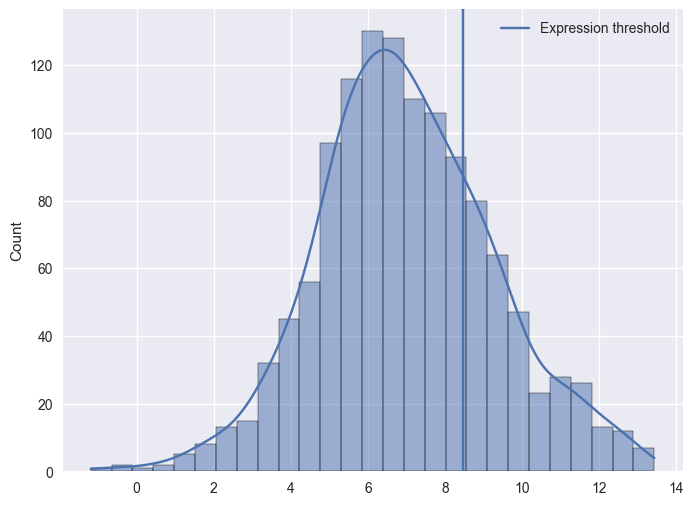

In [44]:
p90_threshold.plot()
p75_threshold.plot()

## Visualizing gene data

In [56]:
gene_data_dict = {k: GeneData(data=v, 
                              data_transform=lambda x: np.log2(x), 
                              absent_expression=np.nan) 
                  for k, v in raw_count.items()}

In [57]:
gene_data_dict

{'sample_0': <pipeGEM.data.data.GeneData at 0x26187ea2ad0>,
 'sample_1': <pipeGEM.data.data.GeneData at 0x26187ea2680>,
 'sample_2': <pipeGEM.data.data.GeneData at 0x26187ea2410>,
 'sample_3': <pipeGEM.data.data.GeneData at 0x26187ea0940>,
 'sample_4': <pipeGEM.data.data.GeneData at 0x26187ea22f0>,
 'sample_5': <pipeGEM.data.data.GeneData at 0x26187ea2230>,
 'sample_6': <pipeGEM.data.data.GeneData at 0x26187ea23b0>,
 'sample_7': <pipeGEM.data.data.GeneData at 0x26187ea09a0>,
 'sample_8': <pipeGEM.data.data.GeneData at 0x26187ea08e0>}

In [58]:
agg_data = GeneData.aggregate(gene_data_dict, prop="data")

In [59]:
corr_result = agg_data.corr()

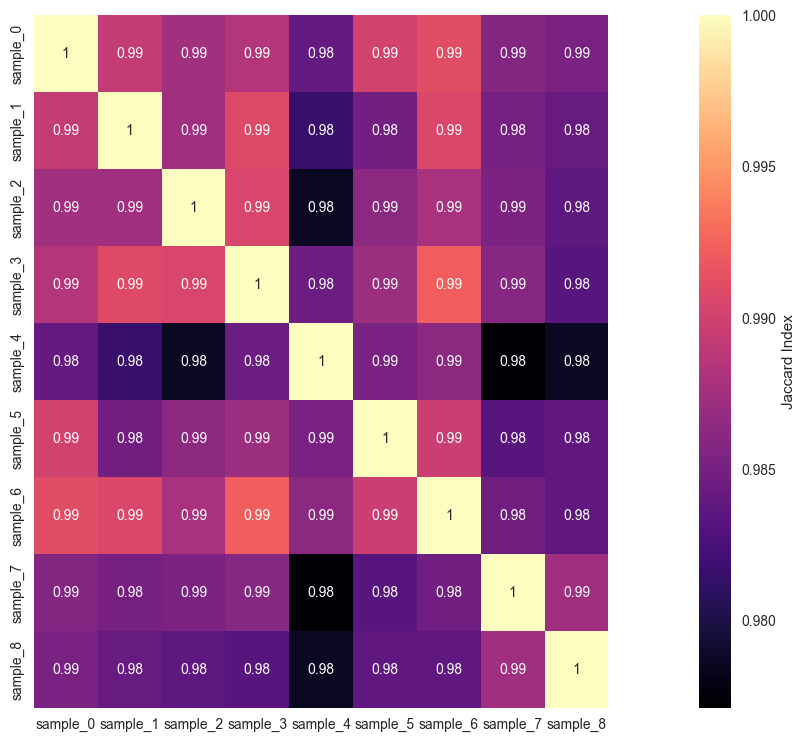

In [60]:
corr_result.plot()

In [55]:
agg_data["sample_0"]

100039108    1067.383338
100041375    1475.617641
100042918     142.162767
100043349     247.981313
100043472     618.675705
                ...     
99439         932.618833
9952           26.424569
9954           88.801528
99586          78.675246
99712         142.590572
Name: sample_0, Length: 1375, dtype: float64

In [61]:
pca_result = agg_data.dim_reduction(method="PCA")

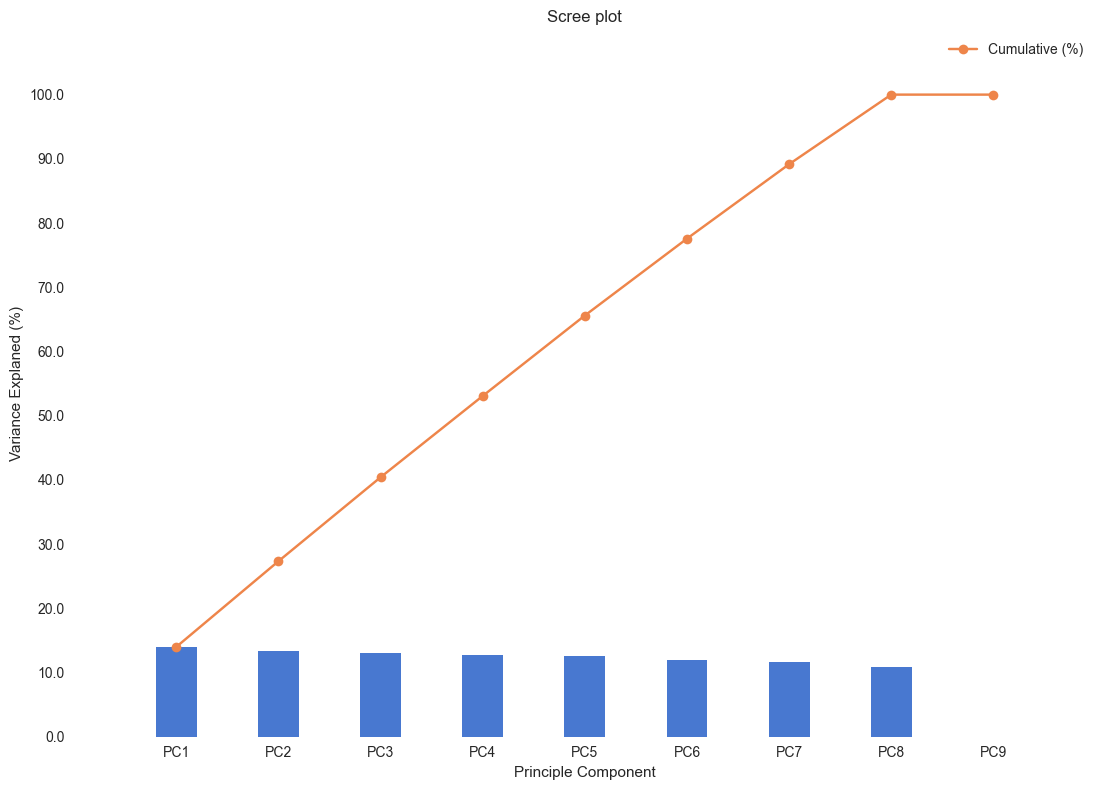

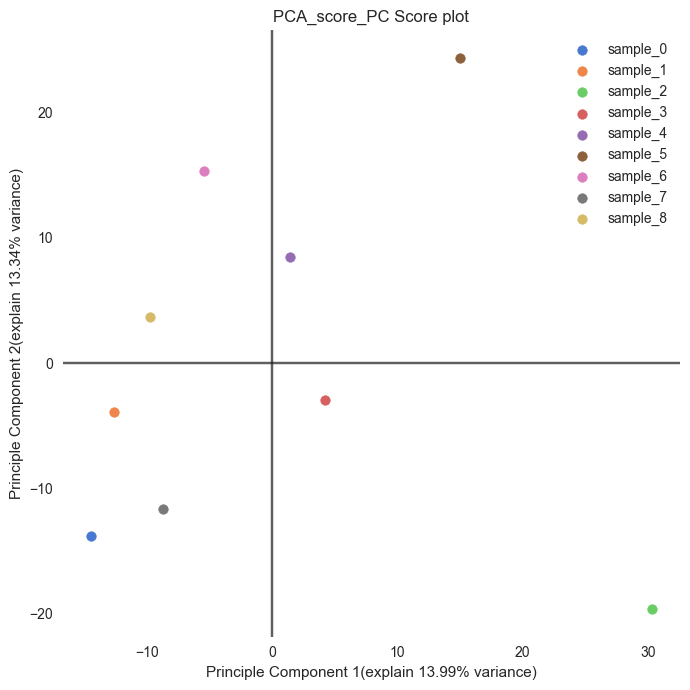

In [62]:
pca_result.plot()

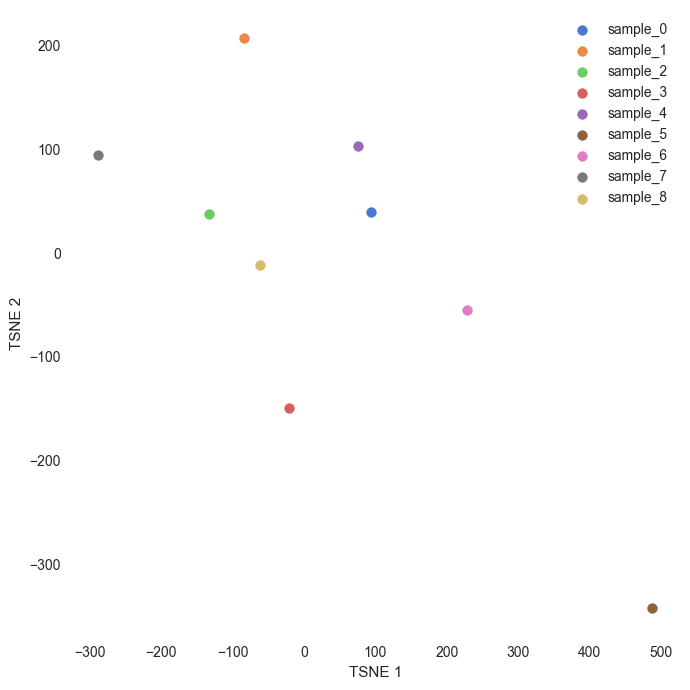

In [63]:
tsne_result = agg_data.dim_reduction(method="TSNE")
tsne_result.plot()

C:\Users\user\mambaforge\envs\py310\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


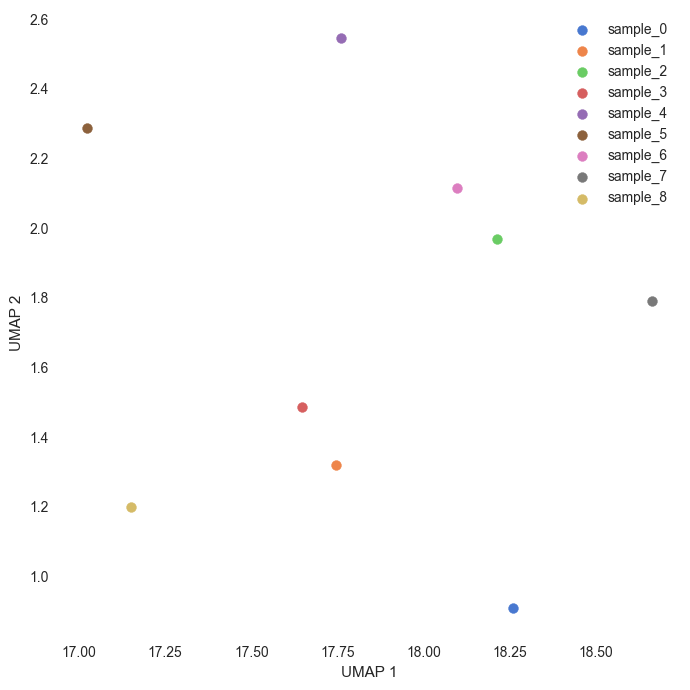

In [64]:
tsne_result = agg_data.dim_reduction(method="UMAP")
tsne_result.plot()

## Medium data

In [7]:
human = load_remote_model("Human-GEM")

Model Human-GEM is already downloaded
Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-14


In [8]:
human.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
MAM01291e,MAR00566,0.3888,22,0.01%
MAM01771e,MAR00567,0.01104,20,0.00%
MAM01371e,MAR00569,1000,10,10.44%
MAM01741e,MAR00571,0.1629,22,0.00%
MAM01689e,MAR00573,0.4173,22,0.01%
MAM00094e,MAR00575,0.1049,22,0.00%
MAM01696e,MAR00576,3.583,20,0.07%
MAM02648e,MAR00577,0.6377,20,0.01%
MAM01432e,MAR00618,0.01104,26,0.00%
MAM02456e,MAR00620,0.01104,17,0.00%
